# Invasive Ductal Cancer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score, precision_score, f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import load_model

In [ ]:
# Running locally
# X = np.load('../idc/data/X.npy')
# y = np.load('../idc/data/Y.npy')

In [5]:
# Running in Colab
X = np.load('/content/drive/MyDrive/Colab Notebooks/data/X.npy')
y = np.load('/content/drive/MyDrive/Colab Notebooks/data/Y.npy')

In [6]:
X.shape

(5547, 50, 50, 3)

In [7]:
y.shape

(5547,)

## Data augmentation

In [11]:
from keras.preprocessing.image import ImageDataGenerator

X_scaled = X/255
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)

# Instantiate image data generator
datagen = ImageDataGenerator(rotation_range=90, validation_split=0.3)

# Creates iterators for training images
val_images = datagen.flow(X_train, y_train, subset='validation', batch_size=32)
images = datagen.flow(X_train, y_train, subset='training', batch_size=32)

# Generates a fixed number of augmented images
# images, labels = next(datagen.flow(X_train, y_train, batch_size=X_train.shape[0]))

# # Merge original X_train with augmented images
# X_train = np.row_stack((X_train, images))
# X_train.shape
# 
# # Merge original y_train with augmented image labels
# y_train = np.hstack((y_train, labels))
# y_train.shape

## CNN Model Evaluation

In [ ]:
# Run only if you're not using data augmentation
# X_scaled = X/255
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)

In [ ]:
# Final Model 1 (Based on Janowczyk and Madabhushi 2016)
# Recall:             0.849642
# Precision:          0.713426
# F1 score:           0.775599
# Balanced Accuracy:  0.751906

def init_model1(learning_rate=0.001):
  model = models.Sequential()
  model.add(layers.Conv2D(32, kernel_size=(2,2), input_shape=(50, 50, 3), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(32, kernel_size=(2,2), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(64, kernel_size=(2,2), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(64))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(16))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(1, activation='sigmoid'))
  optimizer = Adagrad(learning_rate=learning_rate)
  model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', Recall(thresholds=0.35), Precision(thresholds=0.35)])
 
  return model

In [ ]:
# Final Model 2 (Elizabeth's version)
# Recall:             0.849642
# Precision:          0.729508
# F1 score:           0.785005
# Balanced Accuracy:  0.765207

def init_model2(learning_rate=0.001):
  model = models.Sequential()
  model.add(layers.Conv2D(100, kernel_size=(3,3), input_shape=(50, 50, 3), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(200, kernel_size=(3,3), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(16))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(1, activation='sigmoid'))
  optimizer = Adagrad(learning_rate=learning_rate)
  model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', Recall(thresholds=0.45), Precision(thresholds=0.45)])
 
  return model

In [ ]:
model = init_model2()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 100)       2800      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 200)       180200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 200)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 24200)             0         
                                                                 
 dense (Dense)               (None, 16)                3

In [ ]:
model = init_model2()
mc = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/model.{epoch:02d}-{val_loss:.2f}.h5', 
                     monitor='val_loss', mode='min', save_best_only=True)
history = model.fit(images,
          validation_data=val_images,
          epochs=1000,
          batch_size=64, 
          verbose=1,
          callbacks=mc)

Epoch 1/1000
85/85 [==============================] - 4s 39ms/step - loss: 0.6931 - accuracy: 0.5475 - recall_2: 0.8174 - precision_2: 0.5352 - val_loss: 0.6916 - val_accuracy: 0.4991 - val_recall_2: 1.0000 - val_precision_2: 0.4991
Epoch 2/1000
85/85 [==============================] - 3s 36ms/step - loss: 0.6585 - accuracy: 0.5890 - recall_2: 0.8532 - precision_2: 0.5615 - val_loss: 0.6304 - val_accuracy: 0.6684 - val_recall_2: 0.6988 - val_precision_2: 0.6722
Epoch 3/1000
85/85 [==============================] - 3s 35ms/step - loss: 0.6448 - accuracy: 0.6442 - recall_2: 0.7348 - precision_2: 0.6164 - val_loss: 0.5964 - val_accuracy: 0.6985 - val_recall_2: 0.8107 - val_precision_2: 0.6681
Epoch 4/1000
85/85 [==============================] - 3s 35ms/step - loss: 0.5940 - accuracy: 0.6990 - recall_2: 0.7516 - precision_2: 0.6783 - val_loss: 0.5911 - val_accuracy: 0.7234 - val_recall_2: 0.7831 - val_precision_2: 0.6873
Epoch 5/1000
85/85 [==============================] - 3s 37ms/step -

KeyboardInterrupt: ignored

In [33]:
y_pred = model.predict(X_test)
model.evaluate(X_test, y_test)

53/53 [==============================] - 6s 120ms/step - loss: 0.4862 - accuracy: 0.7730 - recall_1: 0.8974 - precision_1: 0.6861


[0.4861617088317871, 0.7729730010032654, 0.89737468957901, 0.6861313581466675]

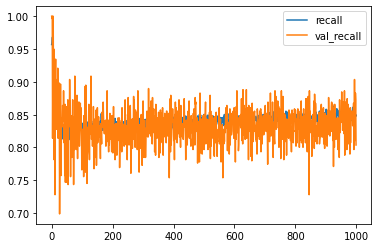

In [ ]:
plt.plot(history.history['recall_1'], label='recall')
plt.plot(history.history['val_recall_1'], label='val_recall')
plt.legend()

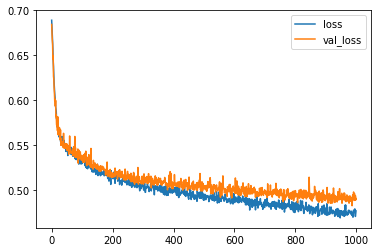

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

Precision Recall Curve

In [34]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred) 

print(f'precision- {precision[:5]}')
print(f'recall- {recall[:5]}')
print(f'threshold- {threshold[:5]}')

precision- [0.51505839 0.51476015 0.51507692 0.51539409 0.51571165]
recall- [1.         0.99880668 0.99880668 0.99880668 0.99880668]
threshold- [0.07750788 0.07837304 0.07916176 0.07949072 0.08222136]


In [35]:
scores = pd.DataFrame({'threshold':threshold,
                       'precision': precision[:-1],
                       'recall':recall[:-1]})
scores.head()

,threshold,precision,recall
0,0.077508,0.515058,1.000000
1,0.078373,0.514760,0.998807
2,0.079162,0.515077,0.998807
3,0.079491,0.515394,0.998807
4,0.082221,0.515712,0.998807


Text(0.5, 0, 'recall')

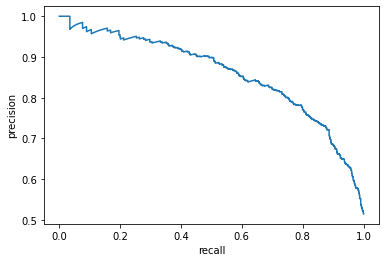

In [36]:
plt.plot(scores['recall'],scores['precision'])
plt.ylabel('precision')
plt.xlabel('recall')

In [37]:
# Find threshold that guarantees 0.85 recall score
threshold = scores[scores['recall'] >= 0.85].threshold.max()
threshold

0.5076203346252441

Predict using test data

In [17]:
from sklearn.metrics import balanced_accuracy_score

In [38]:
def binary_predict(y_pred, custom_threshold=0.45):
    return (y_pred > custom_threshold).astype(int)

updated_preds = binary_predict(y_pred, custom_threshold=threshold)

print(f'Recall:             {recall_score(y_test, updated_preds)}')
print(f'Precision:          {precision_score(y_test, updated_preds)}')
print(f'F1 score:           {f1_score(y_test, updated_preds)}')
print(f'Balanced Accuracy:  {balanced_accuracy_score(y_test, updated_preds)}')

Recall:             0.8496420047732697
Precision:          0.740894901144641
F1 score:           0.791550861589772
Balanced Accuracy:  0.7742768669573725


Creating a report

In [110]:
from numpy import asarray
def create_img_array(image):
    # Convert image to nparray
    X = asarray(image)
    # Get image dimensions
    height = X.shape[0]
    width = X.shape[1]
    # Pad image with white so its dimensions are multiples of 50. Assumes an RGB image
    pad_height = int(np.ceil(height/50))*50
    pad_width = int(np.ceil(width/50))*50
    pad = np.ones((pad_height,pad_width,3), dtype=np.uint8)*255
    pad[:height, :width, :] = X
    # Create an array of 50 x 50 images
    img_array = np.zeros((int(pad_height/50) * int(pad_width/50), 50, 50, 3), dtype=np.uint8)
    for h in range(int(pad_height/50)):
        for w in range(int(pad_width/50)):
            img_array[h*int(pad_width/50)+w,:,:,:] = pad[h*50:(h+1)*50, w*50:(w+1)*50, :]
    return img_array

In [102]:
def generate_report(X_test, y_pred):
    # Remove the top 10% whitest images from predictions
    # white_threshold = max([image.mean() for image in X_test]) * 0.90
    # remove_white_mask = [image.mean() <= white_threshold for image in X_test]
    # X_non_white = X_test[remove_white_mask]
    # y_pred = y_pred[remove_white_mask]

    # Generate report using non-white images
    report = {}
    y_binary = binary_predict(y_pred)
    sum_positive = sum(y_binary)[0]
    percent_positive = round((sum_positive/y_pred.shape[0])*100, 2)
    report['Mean probability across whole slide'] = round(np.mean(y_pred)*100, 2)
    report['Number of high IDC probability patches'] = sum(value == 'High IDC probability' for value in model_diagnosis(X_test,y_pred).values())
    report['Number of medium IDC probability patches'] = sum(value == 'Medium IDC probability' for value in model_diagnosis(X_test,y_pred).values())
    report['Number of low IDC probability patches'] = sum(value == 'Low IDC probability' for value in model_diagnosis(X_test,y_pred).values())
    report['Number of no IDC patches'] = sum(value == 'No IDC' for value in model_diagnosis(X_test,y_pred).values())
    return report

In [80]:
def model_diagnosis(X_test, y_pred):
    diagnosis = {}
    for patch in range(len(X_test)):
        if y_pred[patch] >= 0.9:
            diagnosis[patch] = 'High IDC probability'
        elif y_pred[patch] >= 0.6:
            diagnosis[patch] = 'Medium IDC probability'
        elif y_pred[patch] >= 0.3:
            diagnosis[patch] = 'Low IDC probability'
        else:
            diagnosis[patch] = 'No IDC'
    return diagnosis

In [127]:
img = Image.open('/content/drive/MyDrive/Colab Notebooks/S10-24389 D21_201304241157.png')
img_array = np.array(img)
img_array.shape

(2544, 3424, 3)

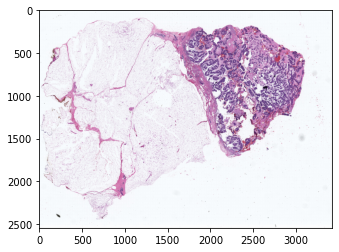

In [128]:
plt.imshow(img_array)

(3519, 50, 50, 3)


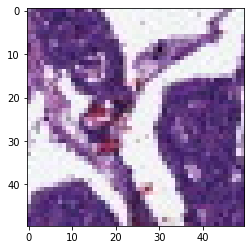

In [141]:
data = create_img_array(img)/255
print(data.shape)
plt.imshow(data[1500])

In [142]:
y_pred_img = model.predict(data)
generate_report(data, y_pred_img)

{'Mean probability across whole slide': 26.05,
 'Number of high IDC probability patches': 19,
 'Number of low IDC probability patches': 824,
 'Number of medium IDC probability patches': 330,
 'Number of no IDC patches': 2346}

In [124]:
img2 = Image.open('/content/drive/MyDrive/Colab Notebooks/S10-22167 B5_201304241131.png')
img_array2 = np.array(img)
img_array2.shape

(2616, 3080, 3)

In [143]:
data2 = create_img_array(img2)/255
y_pred_img2 = model.predict(data2)

In [144]:
generate_report(data2, y_pred_img2)

{'Mean probability across whole slide': 29.32,
 'Number of high IDC probability patches': 20,
 'Number of low IDC probability patches': 792,
 'Number of medium IDC probability patches': 455,
 'Number of no IDC patches': 2019}

In [103]:
a = generate_report(X_test, y_pred)
a

{'Mean probability across whole slide': 57.45,
 'Number of high IDC probability patches': 249,
 'Number of low IDC probability patches': 426,
 'Number of medium IDC probability patches': 593,
 'Number of no IDC patches': 397}

In [91]:
b = model_diagnosis(X_test, y_pred)

Save and load model

In [ ]:
###################################
#   RENAME YOUR MODEL EVERY TIME  #
#     AVOID OVERWRITING MODELS    #
###################################

# From Elizabeth's Colab Notebook
model.save('/content/drive/MyDrive/Colab Notebooks/model_final3.h5')

# Local save
#model.save('../models/model2.h5')

In [123]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/3x3 Kernel models/model.987-0.48.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 100)       2800      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 100)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 22, 22, 200)       180200    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 200)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 24200)             0         
                                                                 
 dense_2 (Dense)             (None, 16)               

In [ ]:
!pip install visualkeras
import visualkeras

     |████████████████████████████████| 795 kB 5.1 MB/s 


In [ ]:
# visualkeras.layered_view(model2).show() # display using your system viewer
# visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model2, to_file='/content/drive/MyDrive/Colab Notebooks/model_final2_img.png').show()